In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


from transformers import *
import os
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
import re
import pickle
import time
import pandas as pd
from pathlib import Path
# from kobert_tokenizer import KoBERTTokenizer
import random
# from torch.utils.tensorboard import SummaryWriter

/home/kaleb/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kaleb/miniconda3/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
# df = pd.read_csv('./data/hackathon_train.csv', encoding='cp949', index_col=0)
df = pd.read_excel('/home/kaleb/Qualcom_comp/data_phase2/train_data.xlsx', sheet_name='Sheet1', index_col=0)

# df = pd.read_csv('./English.csv')
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})

# ages_unique = df['Age'].unique()
# # map ages to 0 ~ len(ages_unique)
# # df['Age'] = df['Age'].map({age: i for i, age in enumerate(ages_unique)})
# print(ages_unique)
df['Age_float'] = df['Age']
df = pd.get_dummies(df, columns=['Age'], prefix='cat')
# split train and test dataframe
# train_df_list = []
# test_df_list = []
# for idx in df['User_ID'].unique():
#     train_df_list.append(df[df['User_ID']==idx][0:40])
#     test_df_list.append(df[df['User_ID']==idx][40:])
    
# train_df = pd.concat(train_df_list, ignore_index=True)
# test_df = pd.concat(test_df_list, ignore_index=True)

In [3]:
# model_name = 'kykim/bert-kor-base'
# model_name = 'monologg/kobigbird-bert-base'
# model_name = 'beomi/kcbert-base'
# model_name = 'skt/kobert-base-v1'
model_name = 'snunlp/KR-BERT-char16424'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-base'

# model_name = 'klue/bert-base'
# model_name = 'klue/roberta-base'
# model_name = 'skt/kogpt2-base-v2'
# model_name = 'kakaobrain/kogpt'


In [4]:
# load embedding

train_result = torch.load(f'/home/kaleb/Qualcom_comp/{model_name.replace("/", "_")}_train_phase2_merged_sorted.pt')
test_result = torch.load(f'/home/kaleb/Qualcom_comp/{model_name.replace("/", "_")}_test_phase2_merged_sorted.pt')

In [5]:
df_merged = pd.read_csv('/home/kaleb/Qualcom_comp/data/hackathon_train.csv', encoding='cp949', index_col=0)
df_merged['Age_float'] = df_merged['Age']
df_merged = pd.get_dummies(df_merged, columns=['Age'], prefix='cat')
df_merged['Short_Answer'] = df_merged['Answer'].apply(lambda x: f"<{(x.split('>')[0])[x.index('<')+1:]}>")
df_merged['Long_Answer'] = df_merged['Answer'].apply(lambda x: x.replace(f"<{(x.split('>')[0])[x.index('<')+1:]}>", ''))
df_merged = df_merged.drop(columns=['Answer'])
df_merged

,User_ID,Gender,MBTI,Q_number,Age_float,cat_20,cat_30,cat_40,Short_Answer,Long_Answer
Data_ID,,,,,,,,,,
1,1,1,INFP,1,30,0,1,0,<아니다>,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...
2,1,1,INFP,2,30,0,1,0,<중립>,다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하며 요즘...
3,1,1,INFP,3,30,0,1,0,<그렇다>,감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 영화관도 ...
4,1,1,INFP,4,30,0,1,0,<중립>,대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고 변수가...
5,1,1,INFP,5,30,0,1,0,<아니다>,평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대로 못합니...
...,...,...,...,...,...,...,...,...,...,...
14384,240,0,ISTJ,44,40,0,0,1,<그렇다>,저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획으로 인한...
14385,240,0,ISTJ,45,40,0,0,1,<그렇다>,저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적도 많기 ...
14386,240,0,ISTJ,46,40,0,0,1,<아니다>,저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이미 정해진...


In [6]:
df = pd.concat([df, df_merged], axis=0)

df = df.sort_values(by=['User_ID'])

df

,User_ID,Gender,MBTI,Q_number,Short_Answer,Long_Answer,Age_float,cat_20,cat_30,cat_40
Data_ID,,,,,,,,,,
1,1,1,INFP,1,<아니다>,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...,30,0,1,0
28,1,1,INFP,28,<그렇다>,이렇게 하면 더 효율적이다고 말했을 때 받아들이는 선이면 짜증 나지 않지만 받아들...,30,0,1,0
29,1,1,INFP,29,<그렇다>,해야 할 일을 생각만 하다가 마지막에 우르르 끝내는 경우가 많습니다. 최근에도 이...,30,0,1,0
30,1,1,INFP,30,<그렇다>,흥미롭습니다. 내가 죽은 뒤 아무것도 없기를 바라지만 귀신을 본다는 사람도 있고 ...,30,0,1,0
31,1,1,INFP,31,<아니다>,저 자신의 에너지가 부족하기 때문에 다른 사람과 시간을 보내면 정신적으로도 육체적...,30,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14365,240,1,ISTP,25,그렇다,논쟁을 하는 걸 보면 무조건 자기 말이 맞는다고 따지는 걸 보면 이기주의 사람들이 ...,30,0,1,0
14366,240,1,ISTP,26,그렇다,전 다른 사람들이 눈치를 잘 보는 편이라 그때 마나 제 자신이 극단적이라는 걸 생각합니다,30,0,1,0
14367,240,1,ISTP,27,아니다,슬픈 영화를 보나 액션 영화를 보나 감정이 매우 빠르게 변하지는 않는 것 같습니다,30,0,1,0


In [7]:
# new_columns = [col for col in df.columns if col not in ['Short_Answer', 'Long_Answer']]
# new_df = pd.DataFrame(columns=new_columns)

# num_samples = df.shape[0]
# k_user_ids = 2
# # print(df['Long_Answer'])
# for i in range(0, num_samples, k_user_ids):
    
#     user_ids = df.iloc[i:i+k_user_ids]['User_ID'].to_list()
    
#     # check if all the user_ids are the same
#     if len(set(user_ids)) == 1:
        
#         # concatenate the "Long_Answer" of k similar user_ids

#         long_answer_concat = df.iloc[i:i+k_user_ids]['Long_Answer'].to_list()
        
#         concat_str = ' 그리고 '.join(long_answer_concat)
        
#         # print(concat_str)
        
#         # since the "User_ID", and all other elements are the same, we can just take the first one
#         new_row = df.iloc[i:i+k_user_ids].head(1)[new_columns]
#         new_row['Long_Answer_concat'] = concat_str
        
#         new_df = pd.concat([new_df, new_row], axis=0)
    

# # print(new_df)
# # print(df.shape)
# assert new_df.shape[0] == df.shape[0] // k_user_ids
# assert new_df.shape[1] == df.shape[1] - 1

# df = new_df

In [8]:
df

,User_ID,Gender,MBTI,Q_number,Short_Answer,Long_Answer,Age_float,cat_20,cat_30,cat_40
Data_ID,,,,,,,,,,
1,1,1,INFP,1,<아니다>,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...,30,0,1,0
28,1,1,INFP,28,<그렇다>,이렇게 하면 더 효율적이다고 말했을 때 받아들이는 선이면 짜증 나지 않지만 받아들...,30,0,1,0
29,1,1,INFP,29,<그렇다>,해야 할 일을 생각만 하다가 마지막에 우르르 끝내는 경우가 많습니다. 최근에도 이...,30,0,1,0
30,1,1,INFP,30,<그렇다>,흥미롭습니다. 내가 죽은 뒤 아무것도 없기를 바라지만 귀신을 본다는 사람도 있고 ...,30,0,1,0
31,1,1,INFP,31,<아니다>,저 자신의 에너지가 부족하기 때문에 다른 사람과 시간을 보내면 정신적으로도 육체적...,30,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14365,240,1,ISTP,25,그렇다,논쟁을 하는 걸 보면 무조건 자기 말이 맞는다고 따지는 걸 보면 이기주의 사람들이 ...,30,0,1,0
14366,240,1,ISTP,26,그렇다,전 다른 사람들이 눈치를 잘 보는 편이라 그때 마나 제 자신이 극단적이라는 걸 생각합니다,30,0,1,0
14367,240,1,ISTP,27,아니다,슬픈 영화를 보나 액션 영화를 보나 감정이 매우 빠르게 변하지는 않는 것 같습니다,30,0,1,0


In [9]:
def set_random(SEED=0):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

class MyDataset(Dataset):
    def __init__(self, data, label, label_idx=0):
        self.data = data
        self.label = label
        self.label_idx = label_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.label[idx][self.label_idx])
    
def convert_mbti_to_label(mbti: str):
    """
    :param mbti: string. length=4
    :return:
    """
    stand = 'ISTJ'  # [0, 0, 0, 0]
    result = []
    for i in range(4):
        if stand[i] == mbti[i]:
            result.append(0)
        else:
            result.append(1)

    return result

MBTI = ['IE', 'SN', 'TF', 'JP']
stand = 'ISTJ'
compl = 'ESFP'
label = df['MBTI'].map(convert_mbti_to_label)
for i in range(4):
    df['is_{}'.format(stand[i])] = label.map(lambda x: x[i])
# df = df.drop(columns=['is_IE'])
    

In [10]:
mbti_categories = {
    'I/E': ["Introversion", "Extraversion"],
    'S/N': ["Sensing", "Intuition"],
    'T/F': ["Thinking", "Feeling"],
    'J/P': ["Judging", "Perceiving"]
}

# now map like this, if is_I == 0, then I, else E, if is_S == 0, then S, else N, and so on

df['Word_I/E'] = df['is_I'].map(lambda x: mbti_categories['I/E'][x])
df['Word_S/N'] = df['is_S'].map(lambda x: mbti_categories['S/N'][x])
df['Word_T/F'] = df['is_T'].map(lambda x: mbti_categories['T/F'][x])
df['Word_J/P'] = df['is_J'].map(lambda x: mbti_categories['J/P'][x])

df

,User_ID,Gender,MBTI,Q_number,Short_Answer,Long_Answer,Age_float,cat_20,cat_30,cat_40,is_I,is_S,is_T,is_J,Word_I/E,Word_S/N,Word_T/F,Word_J/P
Data_ID,,,,,,,,,,,,,,,,,,
1,1,1,INFP,1,<아니다>,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
28,1,1,INFP,28,<그렇다>,이렇게 하면 더 효율적이다고 말했을 때 받아들이는 선이면 짜증 나지 않지만 받아들...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
29,1,1,INFP,29,<그렇다>,해야 할 일을 생각만 하다가 마지막에 우르르 끝내는 경우가 많습니다. 최근에도 이...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
30,1,1,INFP,30,<그렇다>,흥미롭습니다. 내가 죽은 뒤 아무것도 없기를 바라지만 귀신을 본다는 사람도 있고 ...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
31,1,1,INFP,31,<아니다>,저 자신의 에너지가 부족하기 때문에 다른 사람과 시간을 보내면 정신적으로도 육체적...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14365,240,1,ISTP,25,그렇다,논쟁을 하는 걸 보면 무조건 자기 말이 맞는다고 따지는 걸 보면 이기주의 사람들이 ...,30,0,1,0,0,0,0,1,Introversion,Sensing,Thinking,Perceiving
14366,240,1,ISTP,26,그렇다,전 다른 사람들이 눈치를 잘 보는 편이라 그때 마나 제 자신이 극단적이라는 걸 생각합니다,30,0,1,0,0,0,0,1,Introversion,Sensing,Thinking,Perceiving
14367,240,1,ISTP,27,아니다,슬픈 영화를 보나 액션 영화를 보나 감정이 매우 빠르게 변하지는 않는 것 같습니다,30,0,1,0,0,0,0,1,Introversion,Sensing,Thinking,Perceiving


correlation between Gender_Word and I
               count      mean       std  min  25%  50%  75%  max
Gender_Word                                                      
female       10596.0  0.554926  0.496997  0.0  0.0  1.0  1.0  1.0
male          8124.0  0.428360  0.494872  0.0  0.0  0.0  1.0  1.0


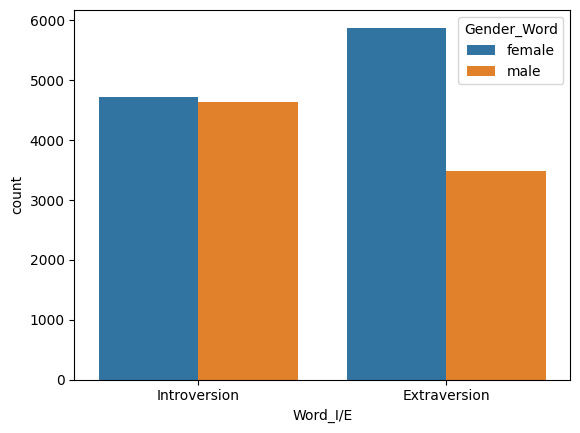

correlation between Gender_Word and S
               count      mean       std  min  25%  50%  75%  max
Gender_Word                                                      
female       10596.0  0.473386  0.499315  0.0  0.0  0.0  1.0  1.0
male          8124.0  0.534712  0.498824  0.0  0.0  1.0  1.0  1.0


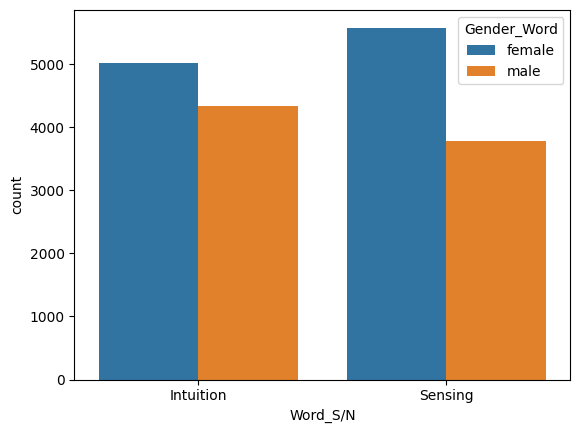

correlation between Gender_Word and T
               count      mean       std  min  25%  50%  75%  max
Gender_Word                                                      
female       10596.0  0.519819  0.499631  0.0  0.0  1.0  1.0  1.0
male          8124.0  0.481536  0.499690  0.0  0.0  0.0  1.0  1.0


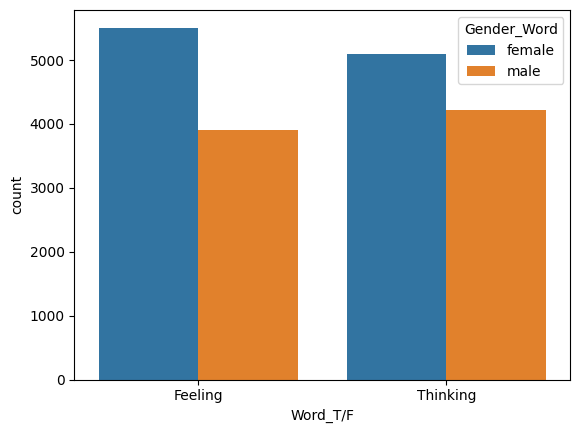

correlation between Gender_Word and J
               count      mean       std  min  25%  50%  75%  max
Gender_Word                                                      
female       10596.0  0.524349  0.499430  0.0  0.0  1.0  1.0  1.0
male          8124.0  0.483013  0.499742  0.0  0.0  0.0  1.0  1.0


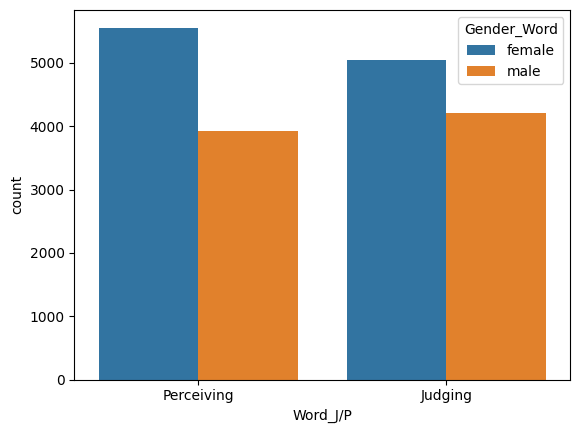

correlation between Age_float and I
            count      mean       std  min  25%  50%  75%  max
Age_float                                                     
20         3384.0  0.627660  0.483500  0.0  0.0  1.0  1.0  1.0
30         8160.0  0.554412  0.497061  0.0  0.0  1.0  1.0  1.0
40         7176.0  0.377926  0.484903  0.0  0.0  0.0  1.0  1.0


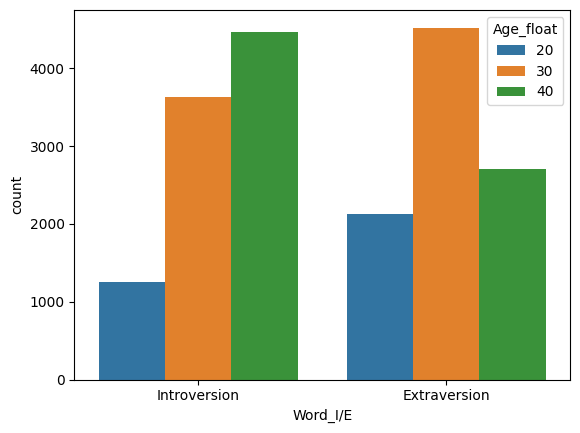

correlation between Age_float and S
            count      mean       std  min  25%  50%  75%  max
Age_float                                                     
20         3384.0  0.514184  0.499873  0.0  0.0  1.0  1.0  1.0
30         8160.0  0.480882  0.499665  0.0  0.0  0.0  1.0  1.0
40         7176.0  0.515050  0.499808  0.0  0.0  1.0  1.0  1.0


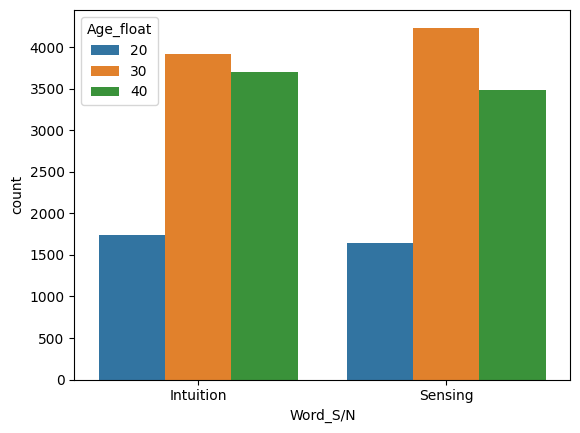

correlation between Age_float and T
            count      mean       std  min  25%  50%  75%  max
Age_float                                                     
20         3384.0  0.421986  0.493949  0.0  0.0  0.0  1.0  1.0
30         8160.0  0.463235  0.498677  0.0  0.0  0.0  1.0  1.0
40         7176.0  0.586957  0.492415  0.0  0.0  1.0  1.0  1.0


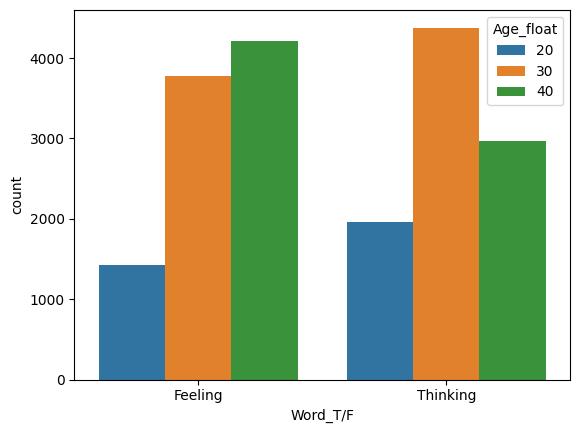

correlation between Age_float and J
            count      mean       std  min  25%  50%  75%  max
Age_float                                                     
20         3384.0  0.588652  0.492151  0.0  0.0  1.0  1.0  1.0
30         8160.0  0.541176  0.498332  0.0  0.0  1.0  1.0  1.0
40         7176.0  0.428094  0.494837  0.0  0.0  0.0  1.0  1.0


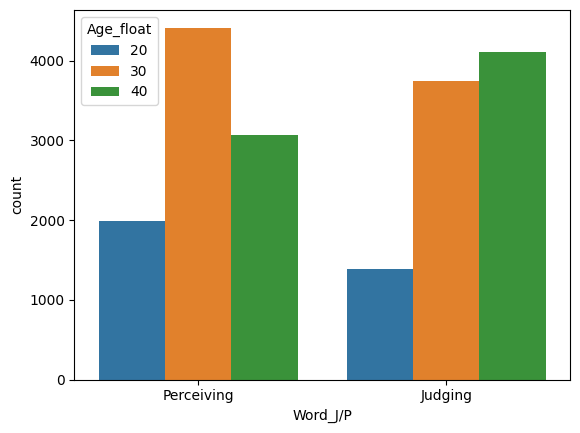

In [11]:
# now let's see the correlation between each mbti columns and "Gender" as well as "Age"
df['Gender_Word'] = df['Gender'].map({0: 'male', 1: 'female'})
import seaborn as sns
import matplotlib.pyplot as plt
# let's utilize "groupby" function
stand = 'ISTJ'
compl = 'ENFP'
for col_name in ['Gender_Word', 'Age_float']:    
    for label, comp in zip(stand, compl):
        print('correlation between {} and {}'.format(col_name, label))
        print(df.groupby(f'{col_name}')[f'is_{label}'].describe())
        # print('correlation value: ', df[f'is_{label}'].corr(df[f'{col_name}']))
        
        # visualize
        sns.countplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', data=df)
        # sns.catplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', kind='count', data=df)
        plt.show()

In [12]:
trade_off = 204

train_df = df[df['User_ID'] <= trade_off]
test_df = df[df['User_ID'] > trade_off]

prop_train, prop_test = len(train_df) / len(df), len(test_df) / len(df)

print(f'prop train = {prop_train}, prop test = {prop_test}')

prop train = 0.7955128205128205, prop test = 0.20448717948717948


In [13]:
train_df.shape, test_df.shape

((14892, 19), (3828, 19))

In [14]:
def train(model, dl, optimizer, criterion, device=1):
    model = model.cuda(device)
    model.train()
    loss_all, acc_all = 0, 0
    
    for x, y in dl:
        x, y = x.cuda(device), y.cuda(device)
        output = model(x)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(axis=1) == y).sum() / len(y)

        loss_all += loss.item()
        acc_all += acc.item()


    loss = loss_all / len(dl)
    acc = acc_all / len(dl)

    return loss, acc

def valid(model, dl, optimizer=None, criterion=None, device=1):
    model = model.cuda(device)
    model.eval()
    loss_all, acc_all = 0, 0
    
    output_list = []
    for x, y in dl:
        x, y = x.cuda(device), y.cuda(device)
        output = model(x)
        loss = criterion(output, y)

        acc = (output.argmax(axis=1) == y).sum() / len(y)

        loss_all += loss.item()
        acc_all += acc.item()

        output_list.append(output.argmax(dim=1).cpu())
        
    loss = loss_all / len(dl)
    acc = acc_all / len(dl)
    
    
#     # userid accuracy
#     result = 0
#     a = torch.cat(output_list)
#     for uid in test_df['User_ID'].unique():
#         idx = test_df[test_df['User_ID']==uid].index
#         if a[idx].count_nonzero().item() > len(a[idx])//2:
#             label = 1
#         else:
#             label = 0
            
#         result += convert_mbti_to_label(test_df[test_df['User_ID']==uid]['MBTI'].unique()[0])[label_idx] == label
        
    
    return loss, acc


In [15]:
def forward(model, dl, device=0):
    pooled = []
    hidden = []
    model.cuda(device)
    model.eval()
    for data in dl:
        data = {k:v.cuda(device) for k,v in data.items()}
        with torch.no_grad():
            output = model(**data, output_hidden_states=True)
        p, h = output.pooler_output, output.hidden_states
        pooled.append(p) # pooler output
        hidden.append(h) # hidden states
    
    mean_embeddings = torch.cat(pooled).mean(dim=0)
    cls_embeddings = torch.cat([h[-1][:,0] for h in hidden]).mean(dim=0)
    return mean_embeddings, cls_embeddings

In [16]:
added_cols = ['Gender', 'Age_float'] + [col for col in train_df.columns if col.startswith('cat')]

# added_cols = []
nums = 3
for i in range(nums):
    added_cols += ['Gender', 'Age_float']
    if i % 3 == 0:
        added_cols += [col for col in train_df.columns if col.startswith('cat')]
        
# for _ in range(nums):
#     added_cols += ['Age']
# for _ in range(nums//3):
#     added_cols += [col for col in train_df.columns if col.startswith('is')]


col_data = train_df[added_cols].values
test_col_data = test_df[added_cols].values

# print(col_data[0][0].shape)
col_data = col_data.astype(float)
test_col_data = test_col_data.astype(float)


col_data = torch.tensor(col_data, dtype=torch.float, device='cuda:0')
test_col_data = torch.tensor(test_col_data, dtype=torch.float, device='cuda:1')


train_result_added = torch.cat([train_result, col_data], dim=1)
test_result_added = torch.cat([test_result, test_col_data], dim=1)


In [17]:
train_result_added.shape, test_result_added.shape
col_data.shape
print(added_cols)

['Gender', 'Age_float', 'cat_20', 'cat_30', 'cat_40', 'Gender', 'Age_float', 'cat_20', 'cat_30', 'cat_40', 'Gender', 'Age_float', 'Gender', 'Age_float']


In [18]:
train_df

,User_ID,Gender,MBTI,Q_number,Short_Answer,Long_Answer,Age_float,cat_20,cat_30,cat_40,is_I,is_S,is_T,is_J,Word_I/E,Word_S/N,Word_T/F,Word_J/P,Gender_Word
Data_ID,,,,,,,,,,,,,,,,,,,
1,1,1,INFP,1,<아니다>,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female
28,1,1,INFP,28,<그렇다>,이렇게 하면 더 효율적이다고 말했을 때 받아들이는 선이면 짜증 나지 않지만 받아들...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female
29,1,1,INFP,29,<그렇다>,해야 할 일을 생각만 하다가 마지막에 우르르 끝내는 경우가 많습니다. 최근에도 이...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female
30,1,1,INFP,30,<그렇다>,흥미롭습니다. 내가 죽은 뒤 아무것도 없기를 바라지만 귀신을 본다는 사람도 있고 ...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female
31,1,1,INFP,31,<아니다>,저 자신의 에너지가 부족하기 때문에 다른 사람과 시간을 보내면 정신적으로도 육체적...,30,0,1,0,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12210,204,0,ENTJ,30,그렇다,저는 사후 세계에 대한 질문이 흥미로운 편입니다. 이유는 사람마다 종교가 다르고 사...,20,1,0,0,1,1,0,0,Extraversion,Intuition,Thinking,Judging,male
12211,204,0,ENTJ,31,그렇다,저는 혼자보다는 다른 사람과 시간을 보내는 것을 좋아합니다. 최근에도 혼자 시간을 ...,20,1,0,0,1,1,0,0,Extraversion,Intuition,Thinking,Judging,male
12212,204,0,ENTJ,32,아니다,저는 이론 중심의 토론에 관심이 많고 원론적인 이야기도 재미있다고 생각합니다. 예를...,20,1,0,0,1,1,0,0,Extraversion,Intuition,Thinking,Judging,male


In [19]:
from sklearn.metrics import accuracy_score
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from thundersvm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from cuml import *
import cudf

import joblib
# import AUC
from sklearn.metrics import roc_auc_score
# from cuml.metrics import roc_auc_score

gpu_id = 0
cudf.set_allocator("managed")
cudf.cuda.select_device(gpu_id)

train_data = train_result_added
test_data = test_result_added

# data_merged = torch.cat([train_data, test_data], dim=0)


def main(label_idx, train_data_func, test_data_func, param1=1, param2=0.085, param3=10):
    MBTI = ['IE', 'SN', 'TF', 'JP']
    # dataset / dataloader
    # quantile_transformer = preprocessing.QuantileTransformer(n_quantiles = 100)#, output_distribution = 'uniform')
    
    train_data = train_data_func.detach().cpu().numpy()
    # train_data = quantile_transformer.fit_transform(train_data)
    # joblib.dump(quantile_transformer, f'./quantile_transformer_{label_idx}.pkl')
    
    
    train_label = train_df['MBTI'].map(convert_mbti_to_label)
    train_label = np.array([train_lab[label_idx] for train_lab in train_label])
    
    test_data = test_data_func.detach().cpu().numpy()
    # test_data = quantile_transformer.transform(test_data)
    test_label = test_df['MBTI'].map(convert_mbti_to_label)
    test_label = np.array([test_lab[label_idx] for test_lab in test_label])
    
    
    data_merged = np.concatenate([train_data, test_data], axis=0)
    label_merged = np.concatenate([train_label, test_label], axis=0)
    # model = KNeighborsClassifier(n_neighbors=param1)
    # svm = SVC(kernel='rbf', C=param1, gamma=param2, probability=True)
    
    # model = DecisionTreeClassifier(max_depth=12, random_state=42)
    # rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=12)
    # model = XGBClassifier(max_depth=12, n_estimators=100, random_state=42, n_jobs=-1)
    # model = LogisticRegression(C = 0.1)
    # model = GradientBoostingClassifier(max_depth=12, n_estimators=100, random_state=42)
    # model = VotingClassifier(estimators=[
    #     ('rf', rf), 
    #     ('svm', svm)], voting='soft', n_jobs=-1)
    
    # models = [CuMLVotingClassifier(estimators=
    #                              [
    #         ('logistic', LogisticRegression(C=1)),
    #         ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_streams=1, max_depth=10, max_features=0.5)),
    #         ('svm', SVC(kernel='rbf', C=1.5, gamma=0.5, probability=True))], voting='soft'),
    #         CuMLVotingClassifier(estimators=
    #                              [
    #                                  ('logistic', LogisticRegression(C=1)),
    #         ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_streams=1, max_depth=8, max_features=0.6)),
    #         ('svm', SVC(kernel='rbf', C=2.5, gamma=0.025, probability=True))], voting='soft'),
    #         CuMLVotingClassifier(estimators=
    #                              [('logistic', LogisticRegression(C=1)),
    #         ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_streams=1, max_depth=18, max_features=0.6)),
    #         ('svm', SVC(kernel='rbf', C=1, gamma=0.085, probability=True))], voting='soft'),
    #         SVC(kernel='rbf', C=3, gamma=0.05, probability=True)
    # ]
    
    model = SVC(kernel='rbf', C=param1, gamma=param2, probability=True)
    # model = KNeighborsClassifier(n_neighbors=param3)#, weights='uniform')
    # svm_model = SVC(kernel='rbf', C=param1, gamma=param2, probability=True)
    # knn_model = KNeighborsClassifier(n_neighbors=param3)
    # model = CuMLVotingClassifier(estimators=[('svm', svm_model), ('knn', knn_model)], voting='soft')
    # model = LogisticRegression(C = param1, max_iter=3000)
    # model = RandomForestClassifier(n_estimators=100, random_state=42)#, max_depth=param1, max_features=param2)
    # model = models[label_idx]
    # model = LogisticRegression(C = 1, max_iter=3000)
    # model = XGBClassifier(mn_estimators=100, random_state=42, n_jobs=-1, gpu_id=gpu_id)
    # print(f'fitting model {model.estimators} for label {label_idx}')
    model.fit(train_data, train_label)
    
    # model.fit(data_merged, label_merged)
    # pred_train = model.predict(train_data)
    
    # MAIN
    # prediction = model.predict(test_data)
    # best_accuracy = accuracy_score(test_label, prediction)
    
    
    prediction = model.predict_proba(test_data)
    # if label_idx == 0:
    #     best_accuracy = roc_auc_score(test_label, prediction[:, 1])
    # else:
    #     best_accuracy = roc_auc_score(test_label, prediction[:, 0])
    best_accuracy = roc_auc_score(test_label, prediction[:, 1])
    # best_accuracy = accuracy_score(test_label, prediction.argmax(axis=1))
    # best_accuracy = accuracy_score(test_label, prediction)
  
    # pred_train = torch.tensor(pred_train, dtype=torch.float, device='cuda:0')
    # prediction = torch.tensor(prediction, dtype=torch.float, device='cuda:1')
    
    # save the models for each label
    # joblib.dump(model, f'./knn_61point47_{MBTI[label_idx]}.pkl')
    
    
    
    return best_accuracy, model#, pred_train, prediction, train_label, test_label

/home/kaleb/miniconda3/lib/python3.10/site-packages/cudf/utils/utils.py:218: FutureWarning: The cudf.set_allocator function is deprecated and will be removed in a future release. Please use rmm.reinitialize (https://docs.rapids.ai/api/rmm/stable/api.html#rmm.reinitialize) instead. Note that `cudf.set_allocator(allocator="managed")` is equivalent to `rmm.reinitialize(managed_memory=True)`.
  warnings.warn(


In [20]:
import warnings
warnings.filterwarnings('ignore')
import csv
import pickle
MBTI = ['IE', 'SN', 'TF', 'JP']
set_random(42)
best_accuracies = {}
models = list()

Csaved = [1.5, 2.5, 1, 3]
gammasaved = [0.05, 0.025, 0.085, 0.5]
for i in range(4):
# i = 0
# max_acc = 0
# for param in range(1, train_result.shape[1], 20):
    result, model = main(i, train_data, test_data, Csaved[i], gammasaved[i])
    models.append(model)
    best_accuracies[MBTI[i]] = result
    # max_acc = max(max_acc, result)
    print(f'Best accuracy for {MBTI[i]}: {result}')
    # print(f'Best accuracy for {MBTI[i]}, and max_features {param}: {result}')
print()
avg = np.mean(list(best_accuracies.values()))
print('avg is ', avg)
# print('max is ', max_acc)

Best accuracy for IE: 0.6159374040443919
Best accuracy for SN: 0.4954351223729715
Best accuracy for TF: 0.5360853482219761
Best accuracy for JP: 0.44559020929213233

avg is  0.5232620209828679


In [22]:
print(f'Best accuracy for each MBTI:\n {best_accuracies}')
# final average accuracy of the 4 models
final_average_accuracy = sum(best_accuracies.values()) / len(best_accuracies)
print(f'Final average accuracy on validation dataset: {final_average_accuracy}')

Best accuracy for each MBTI:
 {'IE': 0.6159374040443919, 'SN': 0.4954351223729715, 'TF': 0.5360853482219761, 'JP': 0.44559020929213233}
Final average accuracy on validation dataset: 0.5232620209828679
